In [1]:
from sigvisa.models.spatial_regression.local_regression import LocalGPs, BCM
from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample, dgaussian
import scipy.stats
import scipy.optimize

In [2]:

def plot_std(x, y, stds):
    x = x.flatten()
    y = y.flatten()
    stds = stds.flatten()
    plot(x, y, color='blue')
    fill_between(x, y, y+2*stds, facecolor='blue', alpha=0.2)
    fill_between(x, y, y-2*stds, facecolor='blue', alpha=0.2)



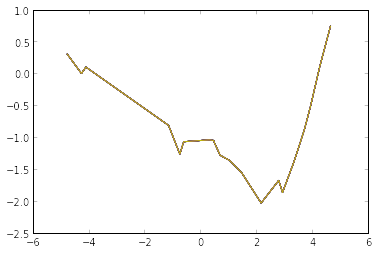

In [3]:
# sample data from the prior
np.random.seed(0)
X = np.asarray(sorted(np.random.rand(20)*10-5)).reshape((-1,1))

cov = GPCov(wfn_params=[1.0], dfn_params=[2.5,], dfn_str="euclidean", wfn_str="se")
noise_var = 0.01
#true_theta = [1.0, 0.5]
KK = mcov(X, cov, noise_var) #cov_matrix(X, X, true_theta) + np.eye(X.shape[0])*noise_var

y = scipy.stats.multivariate_normal(mean=np.zeros((X.shape[0],)), cov=KK).rvs(1)
YY = np.dot(y.T, y)
#y = np.array([prior_sample(X, cov, noise_var) for i in range(5)])

for i in range(y.shape[0]):
    plot(X, y)


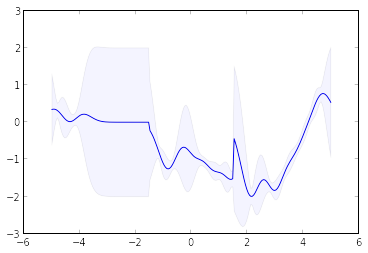

In [4]:
def vec(scalar):
    return np.array((scalar,), dtype=np.float)

cov = GPCov(wfn_params=[1.0], dfn_params=[0.5,], dfn_str="euclidean", wfn_str="se")
#centers = [vec(-4), vec(-2), vec(0), vec(2), vec(4)]
centers = [vec(-3), vec(0), vec(3)]
n_blocks = len(centers)
block_covs = []
lgps = LocalGPs(block_centers=centers, cov_block_params = [(noise_var, 1.0, 0.5)]*n_blocks, X=X, y=y)

xpred = np.linspace(-5, 5, 200).reshape((-1, 1))
ypred = lgps.predict(xpred)
stds = np.sqrt(np.diag(lgps.covariance(xpred)))
plot_std(xpred, ypred, stds)


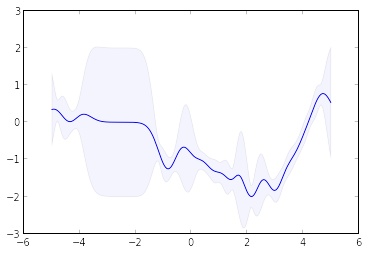

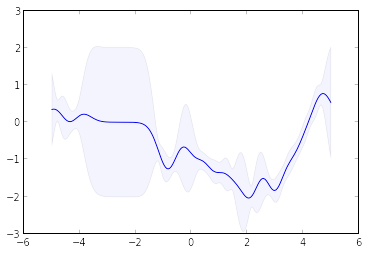

In [5]:
bcm = BCM(test_cov=cov, block_centers=centers, cov_block_params = [(noise_var, 1.0, 0.5)]*n_blocks, X=X, y=y)
means, vs = bcm.predict_dist(xpred, diag=True)
stds = np.sqrt(vs)    
plot_std(xpred, np.array(means), stds)

figure()
m, c = bcm.predict_dist(xpred, noise_var=0.01)
stds = np.sqrt(np.diag(c))    
plot_std(xpred, np.array(m), stds)

In [7]:
llgrad = bcm.llgrad_X()
print llgrad

def ll(xx):
    bcm2 = bcm.update_X(xx, np.concatenate(bcm.cov_block_params))
    ll, g = bcm2.llgrad_hparam()
    return ll

x0 = bcm.flat_X()
llgrad_f = scipy.optimize.approx_fprime(x0, ll, 1e-6)
print llgrad_f

[ 0.74914909  4.01772825 -4.76687733  2.04337598  2.95198008 -4.86811711
  6.37847918 -1.64577081 -0.4401175  -0.4692114  -1.57454217 -0.42820353
 -1.17536401  3.53864085 -1.73880623  1.37084593  0.03228623 -0.20494016
 -2.41320265 -1.35733269]
[ 0.74915141  4.01774312 -4.76686493  2.04337696  2.95198546 -4.86811651
  6.37849678 -1.64577778 -0.44012626 -0.46920912 -1.57453342 -0.42819772
 -1.17536096  3.53863614 -1.73880815  1.37084781  0.03228544 -0.20494534
 -2.41319982 -1.3573314 ]


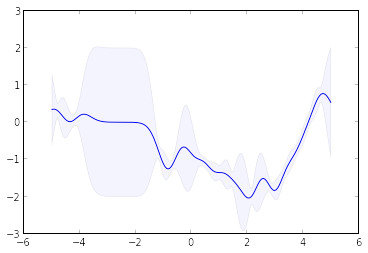

In [8]:
gp = GP(X=X, y=y, noise_var=noise_var, cov_main=cov, compute_ll=True, sort_events=False, compute_grad=True, sparse_invert=False)
ypred = gp.predict(xpred)
stds = np.sqrt(gp.variance(xpred))
plot_std(xpred, ypred, stds)


In [9]:

print gp.grad_ll_wrt_X()

[[ 0.74914909]
 [ 4.01772825]
 [-4.76687733]
 [ 2.04337607]
 [ 2.95198045]
 [-4.86811758]
 [ 6.37847979]
 [-1.6457718 ]
 [-0.44011724]
 [-0.46921102]
 [-1.57454256]
 [-0.42820332]
 [-1.17536488]
 [ 3.53864044]
 [-1.73880555]
 [ 1.37084765]
 [ 0.0322856 ]
 [-0.20493922]
 [-2.4132041 ]
 [-1.35733271]]


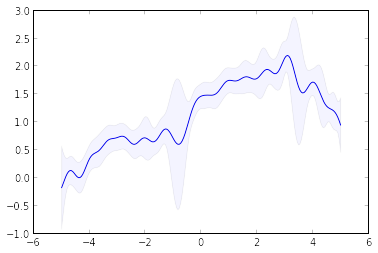

In [10]:
print gp.log_likelihood()
print lgps.likelihood()
print bcm.likelihood()

-10.2880516498
-14.9160213785
block 1 conditional ll 0.63 vs prior -0.56
block 2 conditional ll -2.02 vs prior -2.04
block 3 conditional ll -2.19 vs prior -4.82
block 4 conditional ll -5.41 vs prior -6.14
-10.3519511953


(-10.351951197803476, array([-99.02156489,  -2.35070527,  11.39281016, -92.51503907,
        -2.19565286,  11.37653351,  50.26954989,  -0.85948098,
        19.9752405 , -34.56848232,   0.84379836,  14.99886235,
       -59.38883309,   1.85753683,   7.48860842]))
(-10.351951197803476, array([-99.02156489,  -2.35070527,  11.39281016, -92.51503907,
        -2.19565286,  11.37653351,  50.26954989,  -0.85948098,
        19.9752405 , -34.56848232,   0.84379836,  14.99886235,
       -59.38883309,   1.85753683,   7.48860842]))


In [12]:
print lgps.likelihood_grad()
print gp.ll_grad

[ -1.01923403e+02  -2.56320566e+00   8.87781908e+00  -9.27064177e+01
  -2.18475459e+00   1.10919556e+01   5.39119018e+01   5.13859001e-02
   1.39045521e+01  -5.73472258e+01   1.47428691e+00   1.34637879e+01
  -5.93888331e+01   1.85753683e+00   7.48860842e+00]
[-242.10383723   -2.6990433    65.19192503]


  status: 0
 success: True
    nfev: 31
     fun: -25.814076374206451
       x: array([ 0.00947365,  0.42985922,  2.18277012])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  7.39312321e-04,  -3.11117923e-05,   1.68204165e-05])
     nit: 19


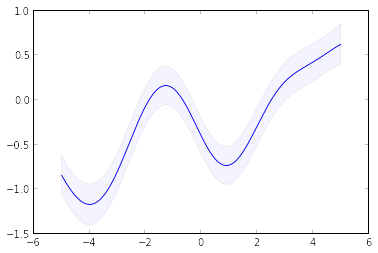

In [12]:
# optimize GP params:
def buildgp(params):
    noise_var = params[0]
    cov = GPCov(wfn_params=params[1:2], dfn_params=params[2:], dfn_str="euclidean", wfn_str="se")
    gp = GP(X=X, y=y[0,:], noise_var=noise_var, cov_main=cov, compute_ll=True, sort_events=False, compute_grad=True)
    return gp

def gp_llgrad(params):
    gp = buildgp(params)
    return -gp.ll, -gp.ll_grad

x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(gp_llgrad, x0, jac=True, bounds=bounds)
print r

gp = buildgp(r.x)
ypred = gp.predict(xpred)
stds = np.sqrt(gp.variance(xpred, include_obs=True))
plot_std(xpred, ypred, stds)


  status: 0
 success: True
    nfev: 67
     fun: -18.817378837239538
       x: array([ 0.00977014,  0.32592926,  1.92514931])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  1.09911086e-04,  -9.31330186e-06,   1.82770710e-05])
     nit: 26


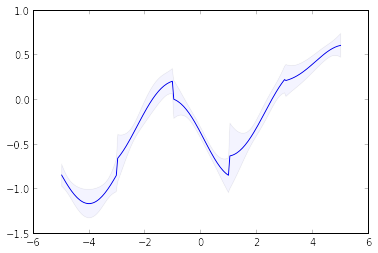

In [13]:
# optimize LGP params:
def build_lgp(params):
    lgps = LocalGPs(block_centers=centers, cov_block_params = [params], X=X, y=y[0,:])
    return lgps

def lgp_llgrad(params):
    lgps = build_lgp(params)
    ll = lgps.likelihood()
    llgrad = lgps.likelihood_grad()
    return -ll, -llgrad

x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(lgp_llgrad, x0, jac=True, bounds=bounds)
print r

lgps = build_lgp(r.x)
ypred = lgps.predict(xpred)
stds = np.sqrt(np.diag(lgps.covariance(xpred)))
plot_std(xpred, ypred, stds)


  status: 0
 success: True
    nfev: 28
     fun: -24.461773778532439
       x: array([ 0.00964667,  0.39213737,  1.92677836])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  9.72585216e-04,  -1.91338453e-05,  -6.20593093e-06])
     nit: 21


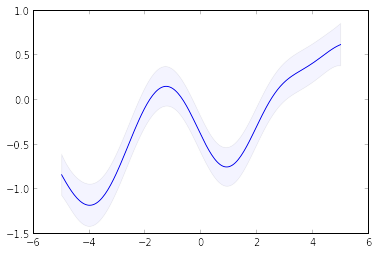

In [14]:
# optimize BCM params:
def build_bcm(params):
    ccov = GPCov(wfn_params=params[1:2], dfn_params=params[2:], dfn_str="euclidean", wfn_str="se")
    bcm = BCM(test_cov=ccov, block_centers=centers, cov_block_params = [params], X=X, y=y[0,:])
    return bcm

def bcm_llgrad(params):
    bcm = build_bcm(params)
    ll, llgrad = bcm.llgrad()
    return -ll, -llgrad

x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(bcm_llgrad, x0, jac=True, bounds=bounds)
print r

bcm = build_bcm(r.x)
m, c = bcm.predict_dist(xpred, noise_var=r.x[0])
stds = np.sqrt(np.diag(c))    
plot_std(xpred, np.array(m), stds)


In [19]:
# pseudooptimize BCM params:
def bcm_pseudo_llgrad(params):
    bcm = build_bcm(params)
    ll, llgrad = bcm.cycle_pseudoll()
    return -ll, -llgrad

def grad_step(f, x, alpha):
    ll, llgrad = f(x)
    delta = llgrad*alpha
    x += delta
    return x, delta

def grad_ascent(f, x0, thresh=0.1):
    step = 1
    delta = np.ones(x0.shape)
    x = x0
    while np.linalg.norm(delta) > thresh:            
        alpha = 1.0/step
        x, delta = grad_step(f, x, alpha)
        step += 1
        if step % 10 == 0:
            print "step %d delta %.3f" % (step, delta)
    return x
    
x0 = np.random.rand(3)
print x0
#rx = grad_ascent(bcm_pseudo_llgrad, x0)

bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(bcm_pseudo_llgrad, x0, jac=True, bounds=bounds)


[ 0.20577932  0.11978814  0.50544452]


  status: 2
 success: False
    nfev: 133
     fun: nan
       x: array([  1.81141874e-02,   2.63604188e+05,   2.02163224e+01])
 message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     jac: array([  5.84509632e-01,  -1.26806360e-05,   1.74694106e-01])
     nit: 42


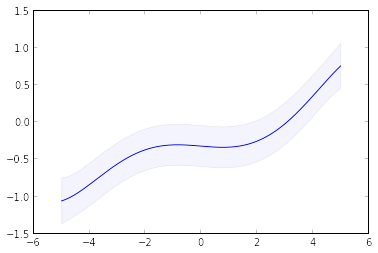

In [20]:
print r
bcm = build_bcm(r.x)
m, c = bcm.predict_dist(xpred, noise_var=r.x[0])
stds = np.sqrt(np.diag(c))    
plot_std(xpred, np.array(m), stds)